In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sklearn.datasets import  make_classification
from sklearn.model_selection import train_test_split

from torch.optim import Adam, RMSprop, SGD, LBFGS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython import display

import copy
import random
import time

sns.set(font_scale=1.5, palette='Set2')

Это игрушечно -исследовательское задание
Перед Вами задача бинарной классификации. Как модель мы будем использывать двуслойный перцептрон.
Изучите, как отрабатывают различные оптимизаторы на этой задаче. Обязательно попробовать  Adam, RMSProp, SGD, L-BFGS. Другие тоже можно

Сделать выводы по полученным результатам.

In [2]:
#  Делаем рандомную задачу бинарной классификации. По умолчанию make_classification порождает объект с 20 признаками. 
# Это значение можно варьировать. И его надо подавать как input_size в моддель
X, Y = make_classification(n_samples=200)

# Делим выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)

# перегоняем все в торч
x_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)

x_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [3]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([160, 20]),
 torch.Size([40, 20]),
 torch.Size([160]),
 torch.Size([40]))

In [4]:
# Cтроим простой перцептрончик: Один линейный слой потом Релу (что это такое, кстати?=)), еще линейный слой и сигмоиду, которая будет выдавать вероятности классов
# hidden size можно варьировать. input_size - кол-во признаков в объекте

class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size

        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(self.hidden_size, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        output = self.sigmoid(output)
        return output

In [5]:
def train_MLP(optimizer_model, lr, title, n_epochs=200):
    model = MLP(20, 10)
    criterion = torch.nn.BCELoss()
    
    optimizer = optimizer_model(model.parameters(), lr=lr)
    sns.set()

    # размер батча. Тоже меняйте если хотите
    batch_size = 8 

    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):

            optimizer.zero_grad()

            # Бьем на батчи. В таком мигрушечном примере это не обязательно, но мы будем делать все по феншую
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]

            # Считаем лосс и добавляем его значение в массив
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            loss_array.append(loss.item())
            loss.backward()
            
            optimizer.step()


        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))
    
        display.clear_output(wait=True)
        plt.figure(figsize =(12, 7))
        plt.title("Обучение MLP. Оптимизатор: {}(lr={})".format(title, lr), fontsize=20)
        plt.plot(epoch_array, label ="TRAIN")
        plt.plot(epoch_test_array, label ="TEST")
        plt.xlabel("Номер эпохи", fontsize=16)
        plt.ylabel("Функция потерь", fontsize=16)
        plt.legend(loc="best", fontsize=20)
        plt.show()

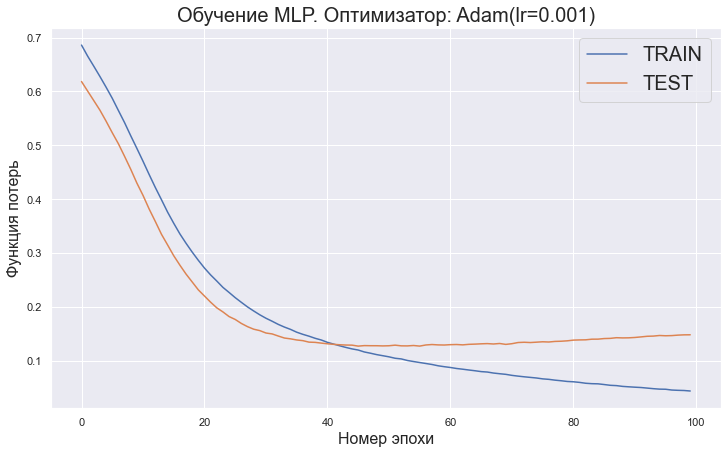

In [6]:
train_MLP(
    optimizer_model=Adam,
    lr=1e-3,
    title="Adam",
    n_epochs=100
)

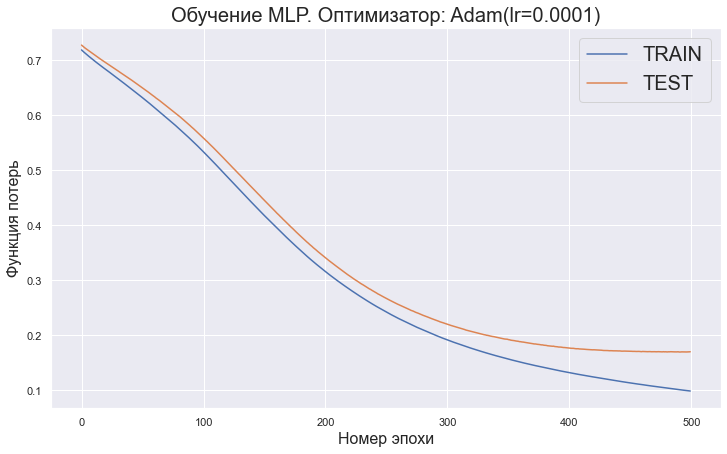

In [7]:
train_MLP(
    optimizer_model=Adam,
    lr=1e-4,
    title="Adam",
    n_epochs=500
)

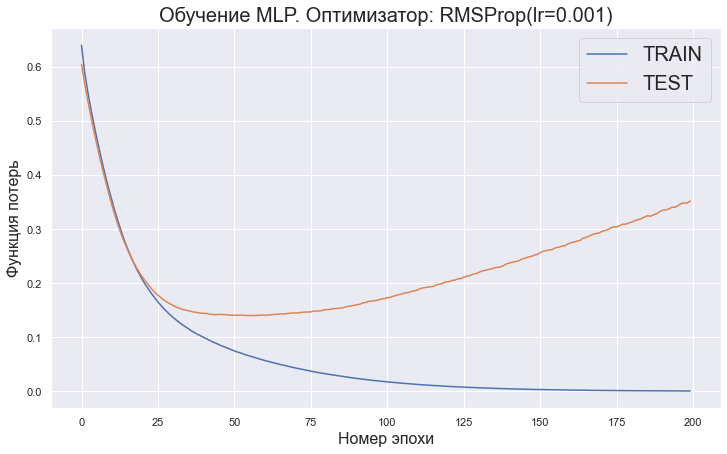

In [8]:
train_MLP(
    optimizer_model=RMSprop,
    lr=1e-3,
    title="RMSProp",
    n_epochs=200
)

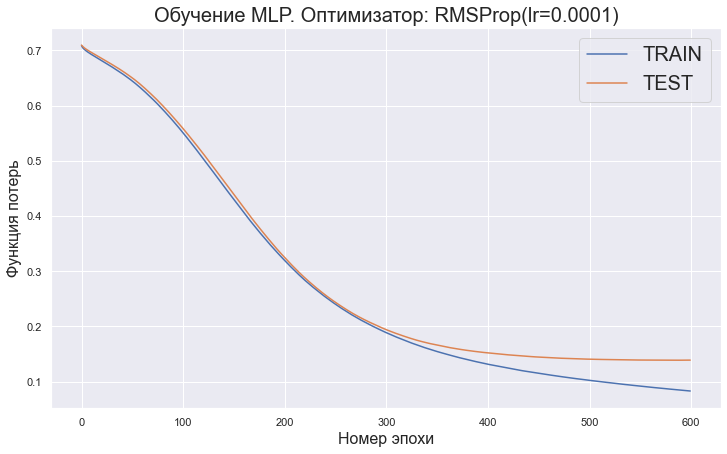

In [9]:
train_MLP(
    optimizer_model=RMSprop,
    lr=1e-4,
    title="RMSProp",
    n_epochs=600
)

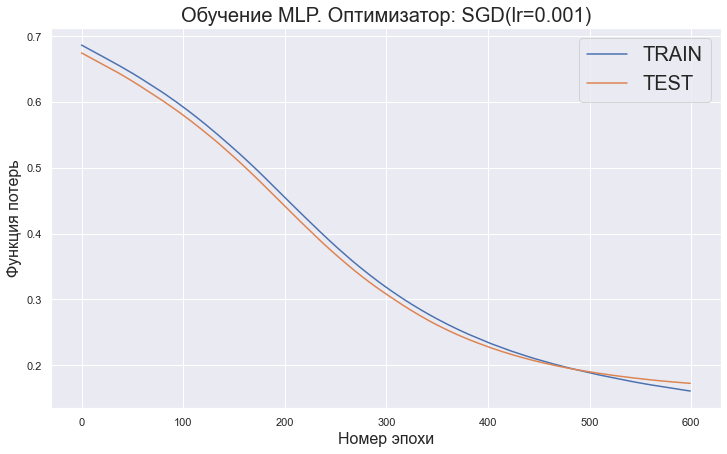

In [10]:
train_MLP(
    optimizer_model=SGD,
    lr=1e-3,
    title="SGD",
    n_epochs=600
)

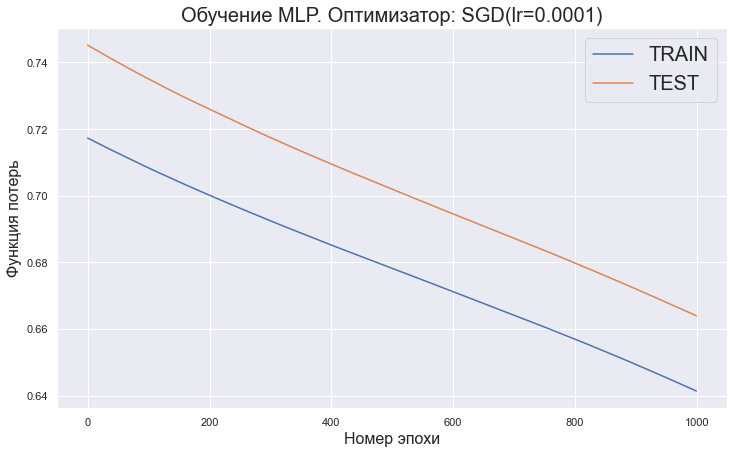

In [11]:
train_MLP(
    optimizer_model=SGD,
    lr=1e-4,
    title="SGD",
    n_epochs=1000
)

In [65]:
def train_MLP_LBFGS(lr, n_epochs=200):
    model = MLP(20, 10)
    criterion = torch.nn.BCELoss()
    
    optimizer = LBFGS(model.parameters(), lr=lr, history_size=3, max_iter=4)
    sns.set()

    # размер батча. Тоже меняйте если хотите
    batch_size = 256

    epoch_array = []
    epoch_test_array = []
    for epoch in range(n_epochs):

        # Тут игрушечный пример как делить на батчи
        permutation = torch.randperm(x_train.size()[0])
        loss_array = []

        model.train()
        for i in range(0,x_train.size()[0], batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = x_train[indices], y_train[indices]
        
            def closure():
                optimizer.zero_grad()
                outputs = model.forward(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
                loss_array.append(loss.item())
                loss.backward()
                return loss
        
            optimizer.step(closure)

        # Будем проверять как отрабатывает модель на тестовом датасете (ЗАЧЕМ?)
        # ТАк еж разбиваем на батчи, считаем лосс, но веса модели не обновляем
        test_permutation = torch.randperm(x_test.size()[0])
        loss_test_array = []
        model.eval()
        for i in range(0,x_test.size()[0], batch_size):

            indices = test_permutation[i:i+batch_size]
            batch_x, batch_y = x_test[indices], y_test[indices]
            outputs = model.forward(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)
            loss_test_array.append(loss.item())

        # усредняем лосс на обучении и тесте по эпохе  и выводим график
        epoch_array.append(np.mean(loss_array))
        epoch_test_array.append(np.mean(loss_test_array))
    
        display.clear_output(wait=True)
        plt.figure(figsize =(12, 7))
        plt.title("Обучение MLP. Оптимизатор: LBFGS(lr={})".format(lr), fontsize=20)
        plt.plot(epoch_array, label ="TRAIN")
        plt.plot(epoch_test_array, label ="TEST")
        plt.xlabel("Номер эпохи", fontsize=16)
        plt.ylabel("Функция потерь", fontsize=16)
        plt.legend(loc="best", fontsize=20)
        plt.show()

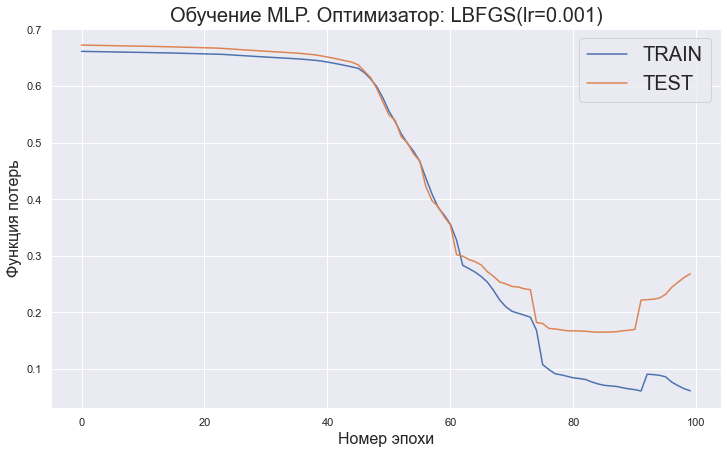

In [71]:
train_MLP_LBFGS(lr=1e-3, n_epochs=100)

ОПИШИТЕ ПОЛУЧЕНННЫЕ РЕЗУЛЬТАТЫ

Перцептрону, как модели машинного обучения, свойственно обучение - об этом свидетельствует резкий рост функции потерь на тестовой выборке, при этом ошибка на тренировочной выборке не сильно, но падает.

Также кривые обучения существенно отличаются, а значит оптимизатор существенно влиять на поведение моделей при обучении. Благодаря каким-то оптимизаторам скорость обучения возрастает (к примеру с оптимизатором Adam модель обучается где-то за 100 эпох). Какие-то оптимизаторы, наоборот, замедляют обучение (К примеру для модели с оптимизатором SGD не хватило и 1000 эпох). Более того, поведение кривой также зависит от типа оптимизатора: с оптимизаторами SGD и Adam ошибка падает с одинаковой скоростью, а для оптимизаторов LBFGS и RMSprop ошибка начинает с какого-то времени расти на тестовой выборке).

Существенный вклад также вносят параметры оптимизаторов. К примеру, чем меньше learning rate, тем меньшей ошибки мы можем добиться, при этом нужно потратить больше времени на обучение.